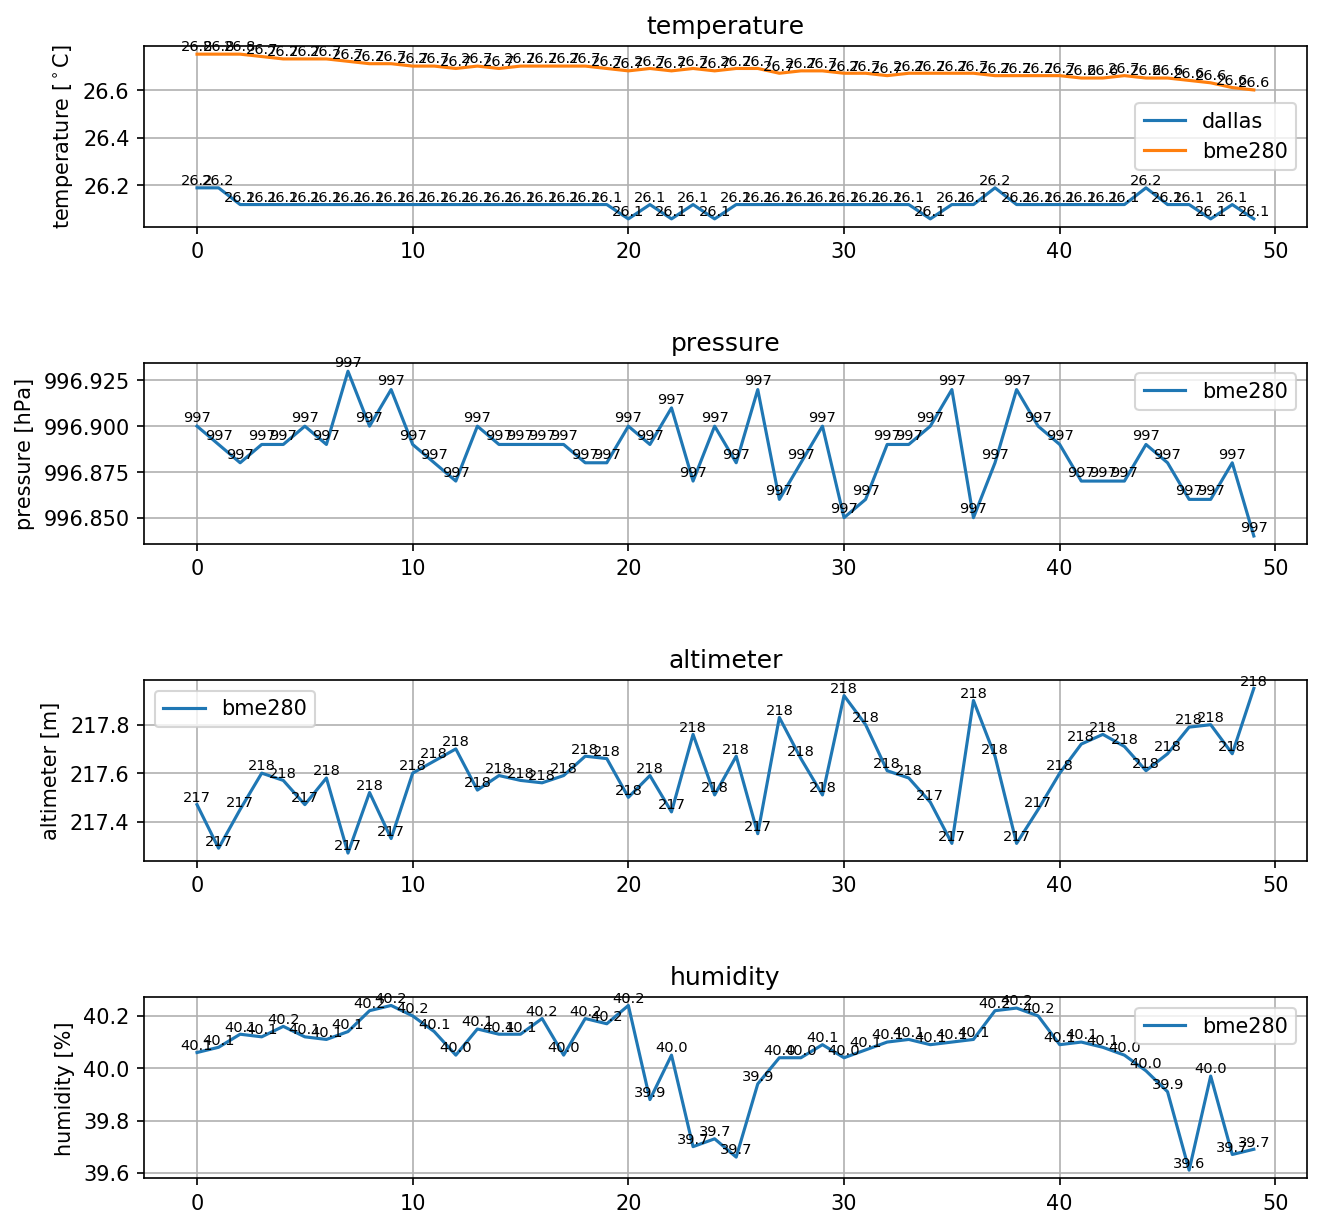

In [ ]:

# -*- coding: utf-8 -*-
# =================================
# Python 3
# Jupyter Notebook 6.0.0
# Author: hqrrr
# Date of last update: Nov. 2020
# =================================
import serial
import matplotlib.pyplot as plt
from drawnow import * # real time plot lib, pip install drawnow
import atexit
import time
from IPython import display

# =================================
#            settings
# =================================
# magic commands for jupyter notebook
# display art of matplotlib
#%matplotlib tk
#%matplotlib notebook
%matplotlib inline

# settings of arduino serial port
serialPort = "COM6"
baudRate = 9600
arduino = serial.Serial(serialPort,baudRate,timeout = 1)
print("[Settings] Port: %s , baud rate: %d" %(serialPort, baudRate))

#activate interactive mode of matplotlib
plt.ion()

# font size of the point label
fz = 7



# =================================
values = []
temperature_dallas = []
temperature = []
pressure = []
altimeter = []
humidity = []

# functions
#def doAtExit():
#    arduino.close() # close arduino serial port
#    print("Close serial")
#    print("arduino.isOpen() = " + str(arduino.isOpen())) # True: open, False: closed
    
def plotValues():
    plt.subplots_adjust(wspace = 0, hspace = 0.75)
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['figure.dpi'] = 150
    plt.subplot(411)
    plt.title("temperature") # plot title
    plt.grid(True) # show grid, True or False
    plt.ylabel("temperature [$^\circ$C]") # label of axis y
    plt.plot(temperature_dallas,"-",label="dallas")
    plt.plot(temperature,"-",label="bme280")
    plt.legend(loc="best") # label location
    
    # label data points on plot
    for x, y in enumerate(temperature_dallas):
        plt.text(x, y+0.001, '%.1f' % y, ha='center', va= 'bottom',fontsize=fz)
    for x, y in enumerate(temperature):
        plt.text(x, y+0.001, '%.1f' % y, ha='center', va= 'bottom',fontsize=fz)
    
    plt.subplot(412)
    plt.title("pressure") # plot title
    plt.grid(True) # show grid, True or False
    plt.ylabel("pressure [hPa]") # label of axis y
    plt.plot(pressure,"-",label="bme280")
    plt.legend(loc="best") # label location
    
    # label data points on plot
    for x, y in enumerate(pressure):
        plt.text(x, y+0.001, '%.0f' % y, ha='center', va= 'bottom',fontsize=fz)
    
    plt.subplot(413)
    plt.title("altimeter") # plot title
    plt.grid(True) # show grid, True or False
    plt.ylabel("altimeter [m]") # label of axis y
    plt.plot(altimeter,"-",label="bme280")
    plt.legend(loc="best") # label location
    
    # label data points on plot
    for x, y in enumerate(altimeter):
        plt.text(x, y+0.001, '%.0f' % y, ha='center', va= 'bottom',fontsize=fz)
    
    plt.subplot(414)
    plt.title("humidity") # plot title
    plt.grid(True) # show grid, True or False
    plt.ylabel("humidity [%]") # label of axis y
    plt.plot(humidity,"-",label="bme280")
    plt.legend(loc="best") # label location
    
    # label data points on plot
    for x, y in enumerate(humidity):
        plt.text(x, y+0.001, '%.1f' % y, ha='center', va= 'bottom',fontsize=fz)
    
    
    
#atexit.register(doAtExit) # if program exit, do function doAtExit to close arduino serial port

#print("arduino.isOpen() = " + str(arduino.isOpen())) # True: open, False: closed

# pre-load some dummy data
for i in range(0,50): 
    temperature_dallas.append(0)
    temperature.append(0)
    pressure.append(0)
    altimeter.append(0)
    humidity.append(0)

while True:
    time.sleep(1)  # 1-sec delay for each loop
    while (arduino.inWaiting() == 0): # wait till there is data to plot
        pass
    valueRead = arduino.readline() # type: bytes
    valueRead_str = str(valueRead.decode("utf-8")) # type: bytes -> string
    valueRead_str = valueRead_str.strip()
    valueRead_list = valueRead_str.split(",")
    
    
    # check if value valid
    try:
        for i in range (0,len(valueRead_list)):
            value = float(valueRead_list[i])
            
            if value >= 0:
                if i == 0:
                    temperature_dallas.append(value) # add the value into list
                    temperature_dallas.pop(0) # delete the first value in the list
                elif i == 1:
                    temperature.append(value)
                    temperature.pop(0)
                elif i == 2:
                    pressure.append(value)
                    pressure.pop(0)
                elif i == 3:
                    altimeter.append(value)
                    altimeter.pop(0)
                elif i == 4:
                    humidity.append(value)
                    humidity.pop(0)
                else:
                    print("Error! len(valueRead_list) incorrect")
                
            else:
                print("Invalid! negative number")
        
        drawnow(plotValues)
        display.clear_output(wait=True)
        
    except ValueError:
        print("Invalid! cannot cast")
        print(valueRead_str)
